# Libraries

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot

import warnings
warnings.filterwarnings('ignore')

# Read CSV Data

In [2]:
df_customer = pd.read_csv('Case Study - Customer.csv', delimiter=';')
df_product = pd.read_csv('Case Study - Product.csv', delimiter=';')
df_store = pd.read_csv('Case Study - Store.csv', delimiter=';')
df_transaction = pd.read_csv('Case Study - Transaction.csv', delimiter=';')

# Data Cleansing

## Customer

In [3]:
df_customer.head

<bound method NDFrame.head of      CustomerID  Age  Gender Marital Status Income
0             1   55       1        Married   5,12
1             2   60       1        Married   6,23
2             3   32       1        Married   9,17
3             4   31       1        Married   4,87
4             5   58       1        Married   3,57
..          ...  ...     ...            ...    ...
442         443   33       1            NaN   9,28
443         444   53       0        Married  15,31
444         445   51       0        Married  14,48
445         446   57       0        Married   7,81
446         447   54       1        Married  20,37

[447 rows x 5 columns]>

In [4]:
df_customer.duplicated().sum()

0

In [5]:
df_customer.isnull().sum()

CustomerID        0
Age               0
Gender            0
Marital Status    3
Income            0
dtype: int64

In [6]:
df_customer[df_customer['Marital Status'].isnull()]

,CustomerID,Age,Gender,Marital Status,Income
9,10,34,1,NaN,4
415,416,27,1,NaN,"3,43"
442,443,33,1,NaN,"9,28"


In [7]:
df_customer.dropna(subset=['Marital Status'], inplace=True)

In [8]:
df_customer.dtypes

CustomerID         int64
Age                int64
Gender             int64
Marital Status    object
Income            object
dtype: object

In [9]:
df_customer['Income'] = df_customer['Income'].replace('[,]', '.', regex=True).astype('float')

## Product

In [10]:
df_product.head()

,ProductID,Product Name,Price
0,P1,Choco Bar,8800
1,P2,Ginger Candy,3200
2,P3,Crackers,7500
3,P4,Potato Chip,12000
4,P5,Thai Tea,4200


In [11]:
df_product.duplicated().sum()

0

In [12]:
df_product.isnull().sum()

ProductID       0
Product Name    0
Price           0
dtype: int64

In [13]:
df_product.dtypes

ProductID       object
Product Name    object
Price            int64
dtype: object

## Store

In [14]:
df_store.head()

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,Prima Tendean,Prima,Modern Trade,"-6,2","106,816666"
1,2,Prima Kelapa Dua,Prima,Modern Trade,"-6,914864","107,608238"
2,3,Prima Kota,Prima,Modern Trade,"-7,797068","110,370529"
3,4,Gita Ginara,Gita,General Trade,"-6,966667","110,416664"
4,5,Bonafid,Gita,General Trade,"-7,250445","112,768845"


In [15]:
df_store.duplicated().sum()

0

In [16]:
df_store.isnull().sum()

StoreID       0
StoreName     0
GroupStore    0
Type          0
Latitude      0
Longitude     0
dtype: int64

In [17]:
df_store.dtypes

StoreID        int64
StoreName     object
GroupStore    object
Type          object
Latitude      object
Longitude     object
dtype: object

In [18]:
df_store['Latitude'] = df_store['Latitude'].replace('[,]', '.', regex=True).astype('float')
df_store['Longitude'] = df_store['Longitude'].replace('[,]', '.', regex=True).astype('float')

## Transaction

In [19]:
df_transaction.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,01/01/2022,P3,7500,4,30000,12
1,TR16356,165,01/01/2022,P9,10000,7,70000,1
2,TR1984,183,01/01/2022,P1,8800,4,35200,4
3,TR35256,160,01/01/2022,P1,8800,7,61600,4
4,TR41231,386,01/01/2022,P9,10000,1,10000,4


In [20]:
df_transaction.duplicated().sum()

0

In [21]:
df_transaction.isnull().sum()

TransactionID    0
CustomerID       0
Date             0
ProductID        0
Price            0
Qty              0
TotalAmount      0
StoreID          0
dtype: int64

In [22]:
df_transaction.dtypes

TransactionID    object
CustomerID        int64
Date             object
ProductID        object
Price             int64
Qty               int64
TotalAmount       int64
StoreID           int64
dtype: object

In [23]:
df_transaction['Date'] = pd.to_datetime(df_transaction['Date'])

In [24]:
df_transaction[df_transaction.duplicated(['TransactionID'], keep=False)]

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
6,TR54287,51,2022-01-01,P8,16000,2,32000,2
17,TR26678,321,2022-02-01,P6,18000,3,54000,12
21,TR34291,333,2022-02-01,P7,9400,2,18800,7
52,TR41140,78,2022-04-01,P9,10000,2,20000,14
74,TR84132,22,2022-05-01,P9,10000,7,70000,14
...,...,...,...,...,...,...,...,...
4876,TR91651,197,2022-12-21,P5,4200,2,8400,7
4910,TR57273,376,2022-12-24,P8,16000,1,16000,11
4916,TR75968,209,2022-12-24,P9,10000,7,70000,13
4921,TR18138,375,2022-12-25,P3,7500,6,45000,4


In [25]:
df_transaction.drop_duplicates('TransactionID', keep='last', inplace=True)

# Data Merging

In [26]:
df_merge = pd.merge(df_transaction, df_customer, on=['CustomerID'])
df_merge = pd.merge(df_merge, df_product.drop(columns=['Price']), on=['ProductID'])
df_merge = pd.merge(df_merge, df_store, on=['StoreID'])

In [27]:
df_merge.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,StoreName,GroupStore,Type,Latitude,Longitude
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,10.53,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,Single,0.18,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,Married,4.36,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
3,TR4331,335,2022-08-01,P3,7500,3,22500,12,29,1,Single,4.74,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
4,TR6445,181,2022-10-01,P3,7500,4,30000,12,33,1,Married,9.94,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554


# Model Machine Learning Regression (Time Series)

In [28]:
df_regresi = df_merge.groupby(['Date']).agg({
    'Qty' : 'sum'
}).reset_index()

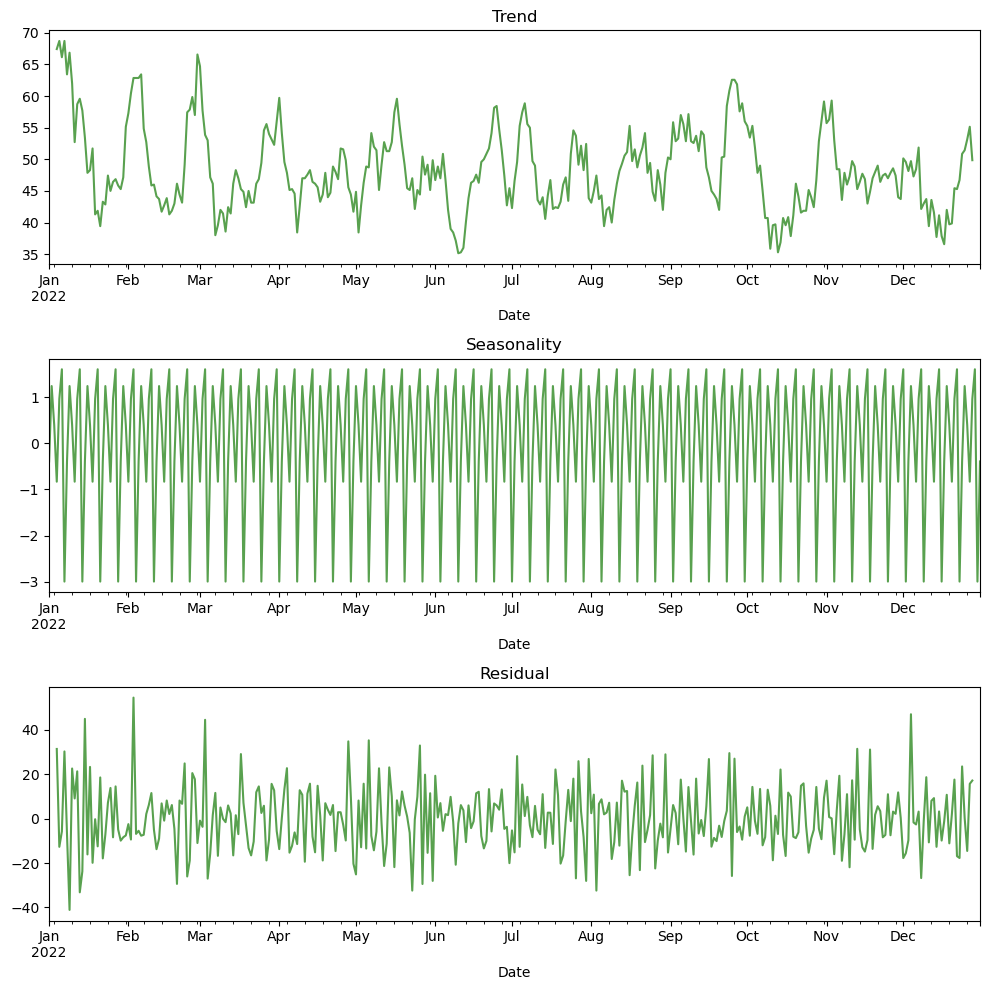

In [29]:
decomposed = seasonal_decompose(df_regresi.set_index('Date'))

plt.figure(figsize=(10, 10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(), color='#59A14F')
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), color='#59A14F')
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), color='#59A14F')
plt.title('Residual')

plt.tight_layout()

## Stationarity Test / Augmented Dickey-Fuller Test

In [30]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_regresi['Qty'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -19.432791
p-value: 0.000000
Critical Values:
	1%: -3.448
	5%: -2.870
	10%: -2.571


<Axes: xlabel='Date', ylabel='Qty'>

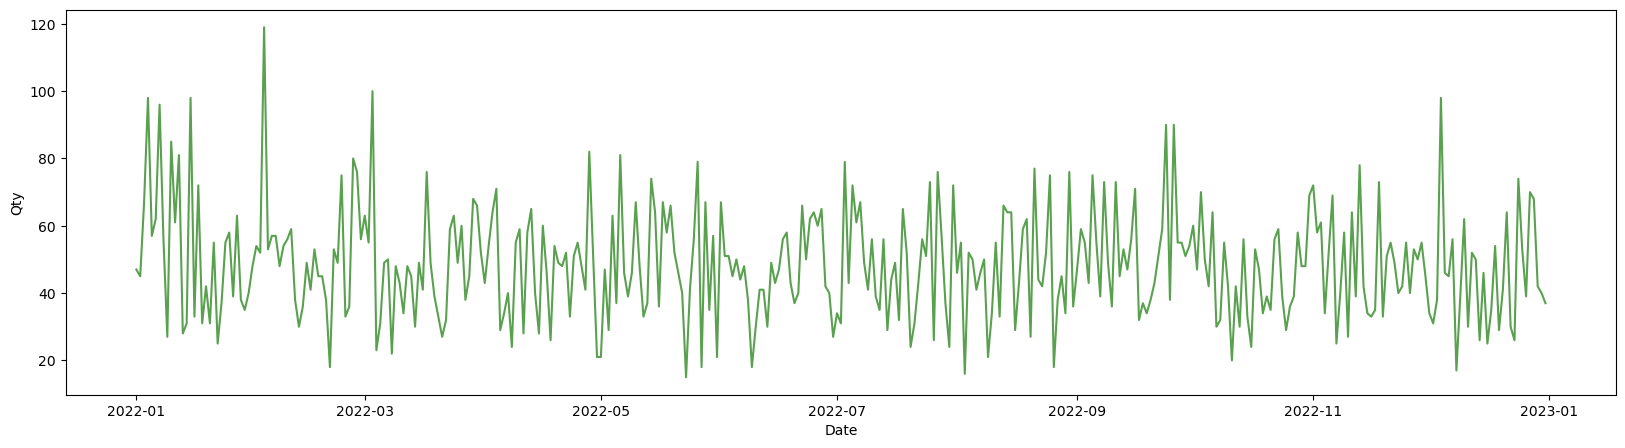

In [31]:
plt.figure(figsize=(20,5))
sns.lineplot(data=df_regresi, x=df_regresi['Date'], y=df_regresi['Qty'], color='#59A14F')

## Finding the Value of d

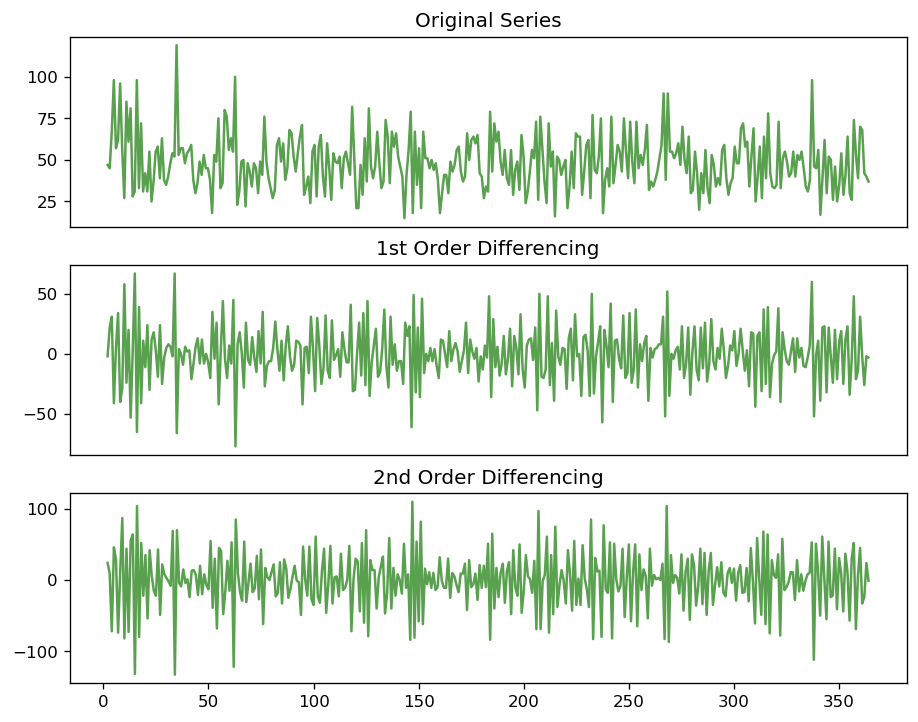

In [32]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

fig, (ax1, ax2, ax3) = plt.subplots(3)

ax1.plot(df_regresi.Qty, color='#59A14F'); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)

ax2.plot(df_regresi.Qty.diff(), color='#59A14F'); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)

ax3.plot(df_regresi.Qty.diff().diff(), color='#59A14F'); ax3.set_title('2nd Order Differencing')

plt.show()

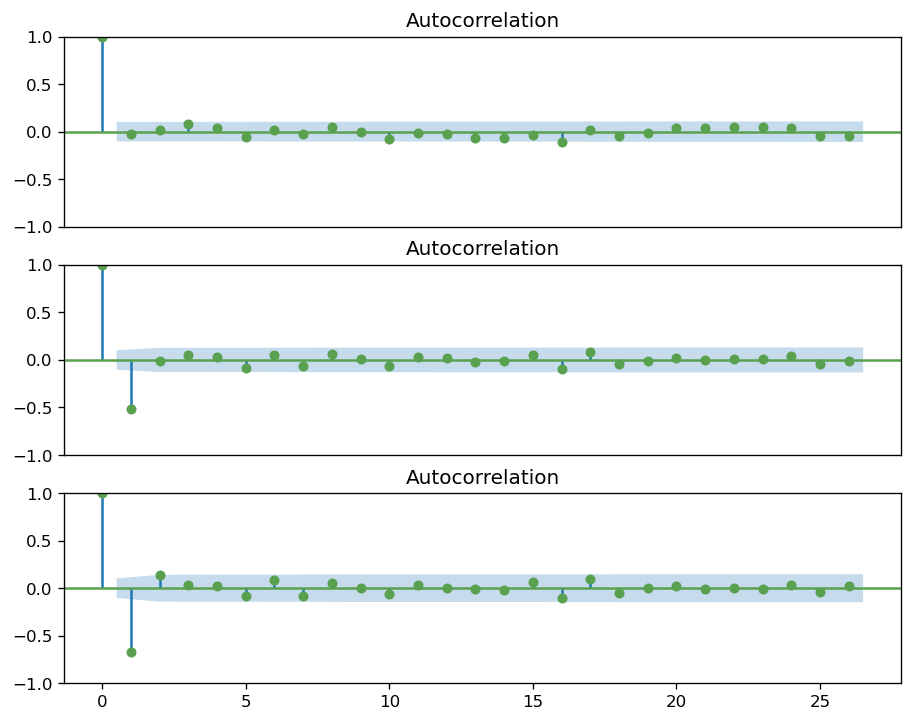

In [33]:
from statsmodels.graphics.tsaplots import plot_acf
fig, (ax1, ax2, ax3) = plt.subplots(3)
plot_acf(df_regresi.Qty, color='#59A14F', ax=ax1); ax1.axes.xaxis.set_visible(False)
plot_acf(df_regresi.Qty.diff().dropna(), color='#59A14F', ax=ax2); ax2.axes.xaxis.set_visible(False)
plot_acf(df_regresi.Qty.diff().diff().dropna(), color='#59A14F', ax=ax3);

## Finding the Value of p

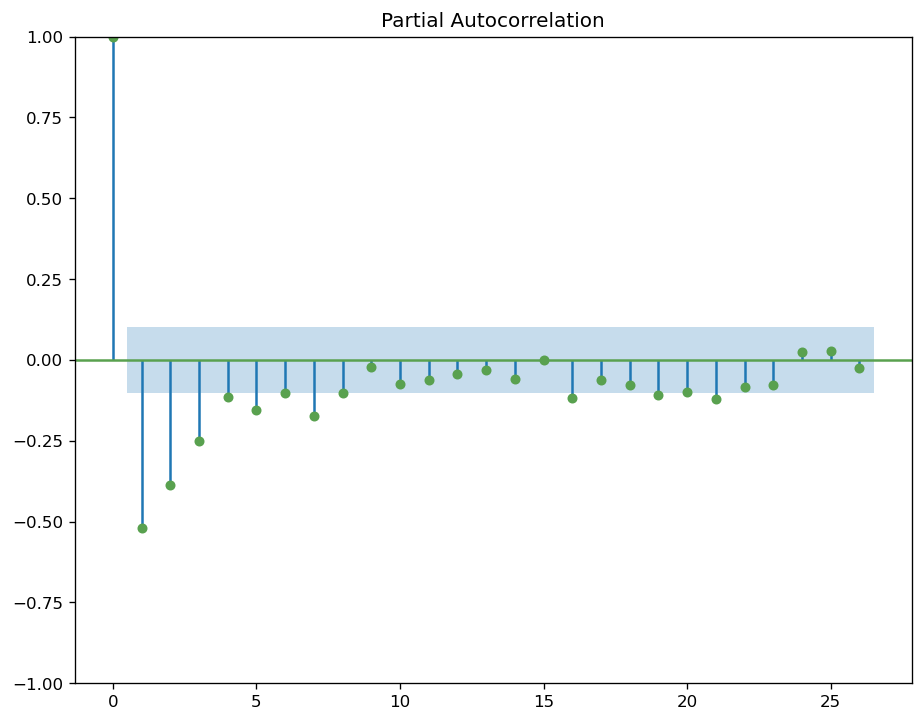

In [34]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_regresi.Qty.diff().dropna(), color='#59A14F');

## Finding the Value of q

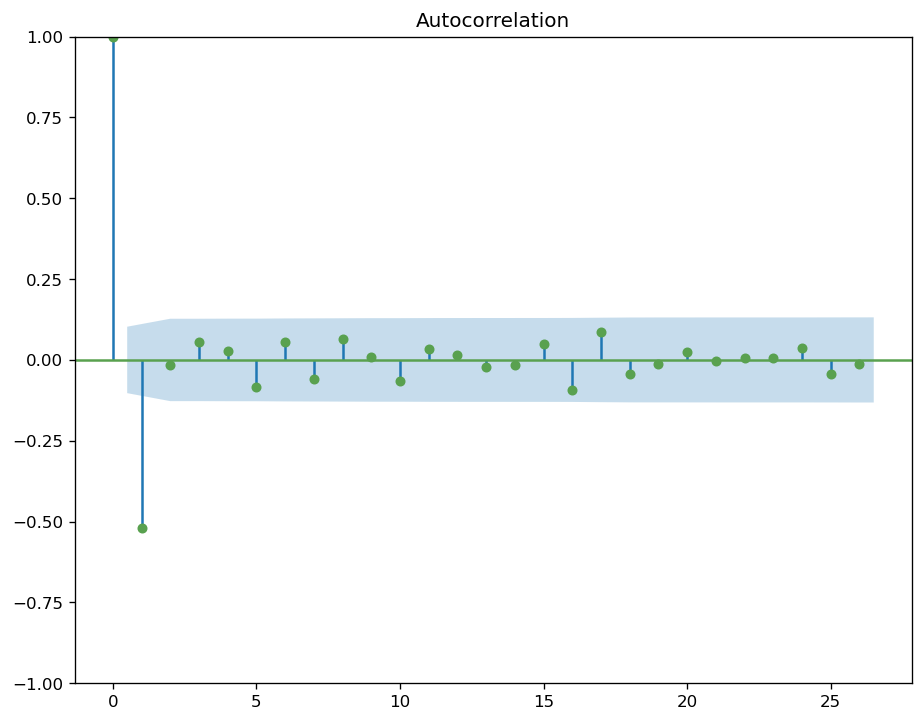

In [35]:
plot_acf(df_regresi.Qty.diff().dropna(), color='#59A14F');

In [54]:
from pmdarima.arima import auto_arima
model = auto_arima(df_train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(df_train)
forecast = model.predict(n_periods=len(df_test))
forecast = pd.DataFrame(forecast, index=df_test.index, columns=['Predictions'])
print(forecast)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2479.571, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2475.371, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2477.309, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2477.314, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3134.172, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2479.347, Time=0.12 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.753 seconds
            Predictions
Date                   
2022-10-20    48.883562
2022-10-21    48.883562
2022-10-22    48.883562
2022-10-23    48.883562
2022-10-24    48.883562
...                 ...
2022-12-27    48.883562
2022-12-28    48.883562
2022-12-29    48.883562
2022-12-30    48.883562
2022-12-31    48.883562

[73 rows x 1 columns]


In [36]:
cut_off = round(df_regresi.shape[0]*0.8)
df_train = df_regresi[:cut_off]
df_test = df_regresi[cut_off:].reset_index(drop=True)
df_train.shape, df_test.shape

((292, 2), (73, 2))

<Axes: xlabel='Date', ylabel='Qty'>

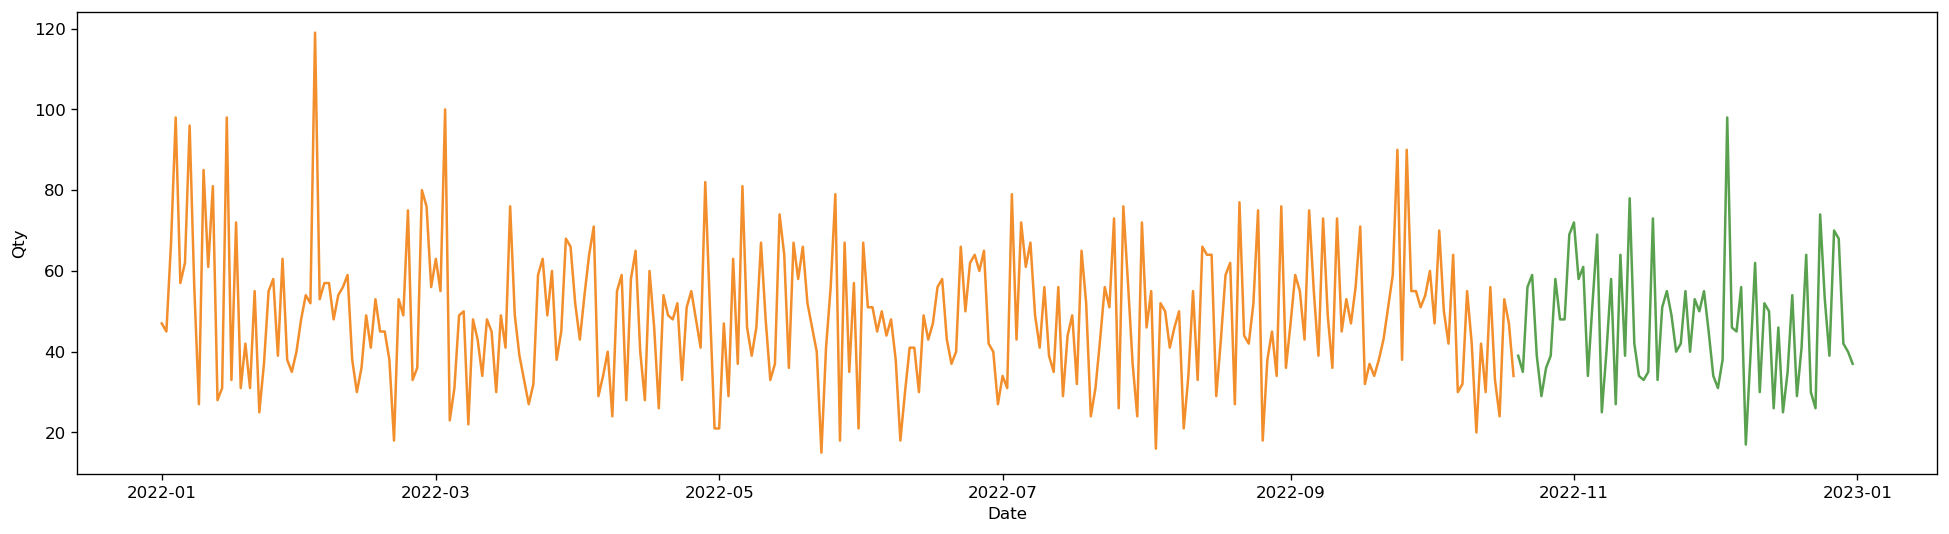

In [37]:
plt.figure(figsize=(20,5))
sns.lineplot(data=df_train, x=df_train['Date'], y=df_train['Qty'], color='#F28E2B')
sns.lineplot(data=df_test, x=df_test['Date'], y=df_test['Qty'], color='#59A14F')

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

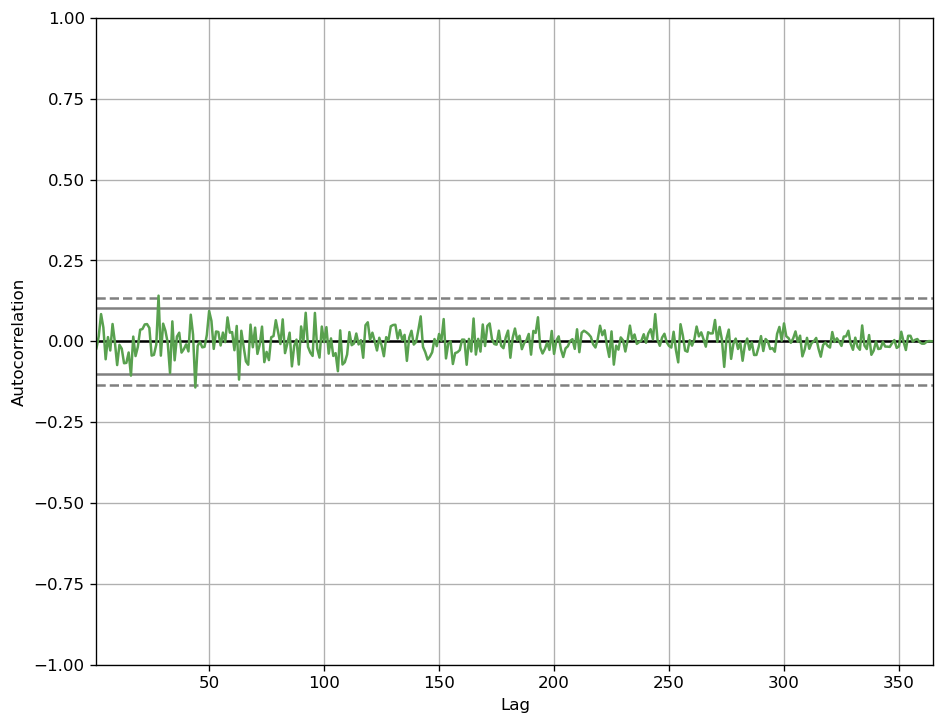

In [38]:
autocorrelation_plot(df_regresi['Qty'], color='#59A14F')

In [39]:
def rmse(y_actual, y_pred):
    """
    function to calculate RMSE
    """
    
    print(f'RMSE value {mean_squared_error(y_actual, y_pred)**0.5}')
    
def eval(y_actual, y_pred):
    """
    function to eval machine learning modelling
    """
    
    rmse(y_actual, y_pred)
    print(f'MAE value {mean_absolute_error(y_actual, y_pred)}')

In [40]:
y = df_train['Qty']

df_train = df_train.set_index('Date')
df_test = df_test.set_index('Date')

RMSE value 16.67300434051283
MAE value 13.423228822209804


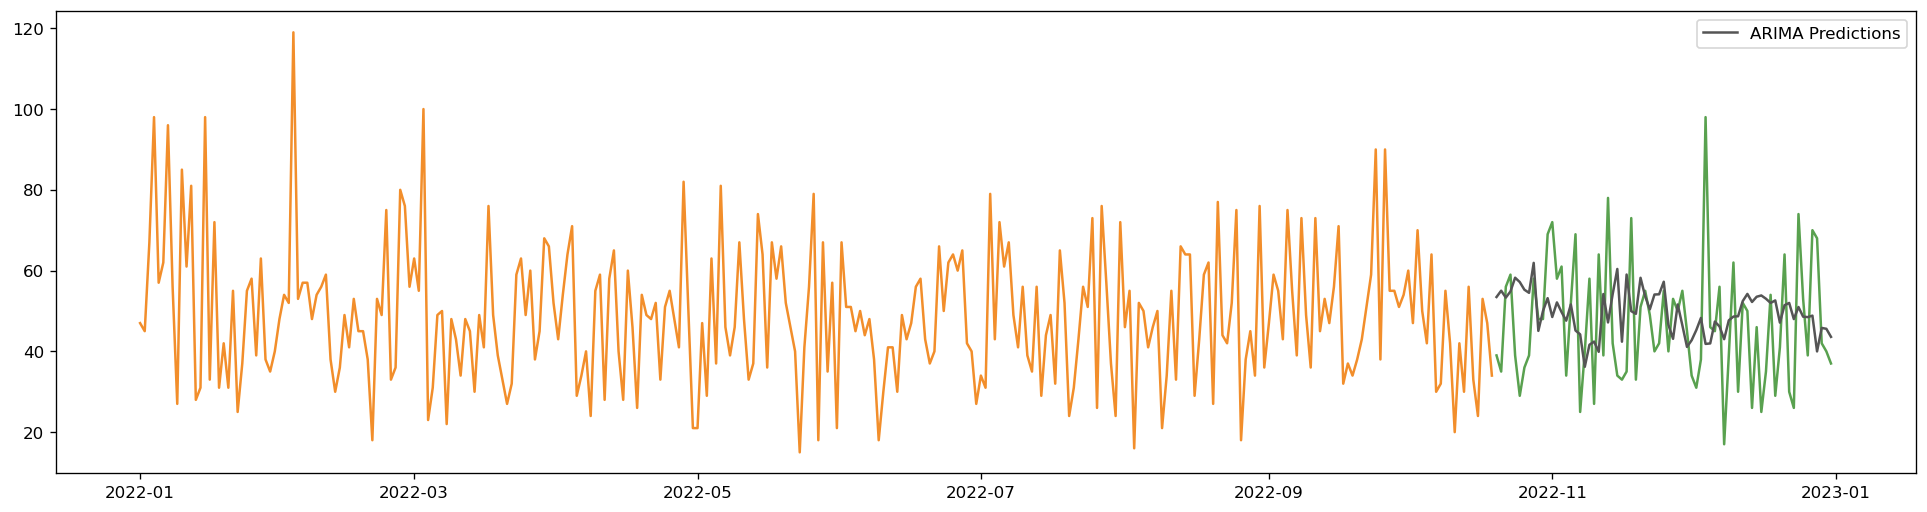

In [41]:
ARIMAmodel = ARIMA(y, order=(50, 0, 2))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(df_test))

y_pred_df = y_pred.conf_int()
y_pred_df['predictions'] = ARIMAmodel.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])
y_pred_df.index = df_test.index
y_pred_out = y_pred_df['predictions']
eval(df_test['Qty'], y_pred_out)

plt.figure(figsize=(20, 5))
plt.plot(df_train['Qty'], color='#F28E2B')
plt.plot(df_test['Qty'], color='#59A14F')
plt.plot(y_pred_out, color='#555555', label='ARIMA Predictions')
plt.legend()

# Model Machine Learning Clustering

In [42]:
df_merge.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,StoreName,GroupStore,Type,Latitude,Longitude
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,10.53,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,Single,0.18,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,Married,4.36,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
3,TR4331,335,2022-08-01,P3,7500,3,22500,12,29,1,Single,4.74,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
4,TR6445,181,2022-10-01,P3,7500,4,30000,12,33,1,Married,9.94,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554


In [43]:
df_merge.corr()

,CustomerID,Price,Qty,TotalAmount,StoreID,Age,Gender,Income,Latitude,Longitude
CustomerID,1.000000,-0.015837,-0.011380,-0.025403,0.006990,-0.022862,-0.017870,0.003156,0.005915,-0.004738
Price,-0.015837,1.000000,-0.355405,0.439146,-0.032526,0.012628,0.011229,0.001667,-0.027900,0.017325
Qty,-0.011380,-0.355405,1.000000,0.621039,0.011340,-0.025567,-0.011661,-0.029621,-0.008228,0.005167
TotalAmount,-0.025403,0.439146,0.621039,1.000000,-0.013560,-0.015795,-0.009794,-0.025999,-0.032737,0.025294
StoreID,0.006990,-0.032526,0.011340,-0.013560,1.000000,-0.004425,-0.002467,0.004311,0.470561,-0.094403
Age,-0.022862,0.012628,-0.025567,-0.015795,-0.004425,1.000000,-0.025092,0.485523,0.010222,0.019690
Gender,-0.017870,0.011229,-0.011661,-0.009794,-0.002467,-0.025092,1.000000,-0.063359,-0.009898,0.000358
Income,0.003156,0.001667,-0.029621,-0.025999,0.004311,0.485523,-0.063359,1.000000,0.018858,0.003488
Latitude,0.005915,-0.027900,-0.008228,-0.032737,0.470561,0.010222,-0.009898,0.018858,1.000000,-0.393919
Longitude,-0.004738,0.017325,0.005167,0.025294,-0.094403,0.019690,0.000358,0.003488,-0.393919,1.000000


In [44]:
df_cluster = df_merge.groupby(['CustomerID']).agg({
    'TransactionID' : 'count',
    'Qty' : 'sum',
    'TotalAmount' : 'sum'
}).reset_index()

In [45]:
df_cluster.head()

,CustomerID,TransactionID,Qty,TotalAmount
0,1,17,60,623300
1,2,12,56,382300
2,3,15,56,446200
3,4,10,46,302500
4,5,7,27,268600


In [46]:
data_cluster = df_cluster.drop(columns=['CustomerID'])

data_cluster_normalize = preprocessing.normalize(data_cluster)

In [47]:
data_cluster_normalize

array([[2.72741856e-05, 9.62618317e-05, 9.99999995e-01],
       [3.13889612e-05, 1.46481819e-04, 9.99999989e-01],
       [3.36172117e-05, 1.25504257e-04, 9.99999992e-01],
       ...,
       [3.20271286e-05, 1.16804822e-04, 9.99999993e-01],
       [2.59862980e-05, 9.92204105e-05, 9.99999995e-01],
       [2.98656046e-05, 9.20856143e-05, 9.99999995e-01]])

In [48]:
K = range(2, 8)
fits = []
score = []

for k in K:
    model = KMeans(n_clusters = k, random_state=0, n_init='auto').fit(data_cluster_normalize)
    
    fits.append(model)
    
    score.append(silhouette_score(data_cluster_normalize, model.labels_, metric='euclidean'))

<Axes: >

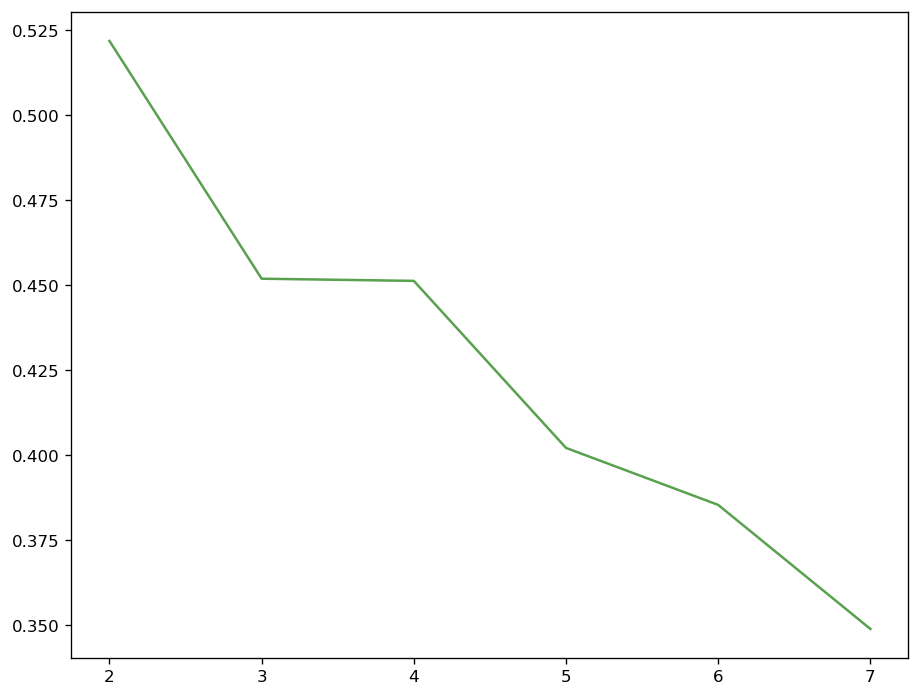

In [49]:
sns.lineplot(x=K, y=score, color='#59A14F')

In [50]:
fits[1]

KMeans(n_clusters=3, n_init='auto', random_state=0)

In [51]:
df_cluster['cluster_label'] = fits[1].labels_

In [52]:
df_cluster.groupby(['cluster_label']).agg({
    'CustomerID' : 'count',
    'TransactionID' : 'mean',
    'Qty' : 'mean',
    'TotalAmount' : 'mean',
})

,CustomerID,TransactionID,Qty,TotalAmount
cluster_label,,,,
0,173,10.884393,40.410405,338332.369942
1,83,10.132530,38.421687,268104.819277
2,188,11.382979,39.936170,403829.787234


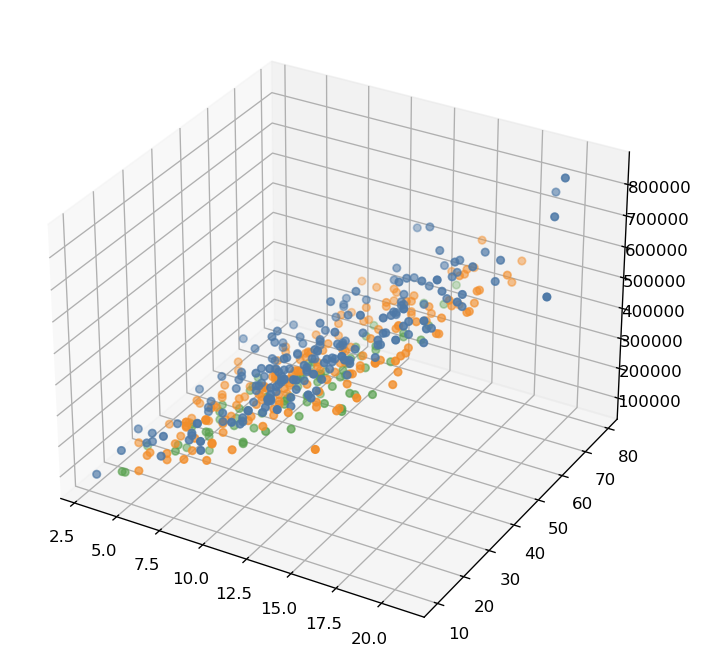

In [53]:
import matplotlib.colors as mcolors

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.array(df_cluster['TransactionID'])
y = np.array(df_cluster['Qty'])
z = np.array(df_cluster['TotalAmount'])

cmap = mcolors.LinearSegmentedColormap.from_list("", ["#F28E2B", "#59A14F", "#4E79A7"])
ax.scatter(x, y, z, c=df_cluster['cluster_label'], cmap=cmap)

plt.show()